# **FEATURE ENGINEERING**

## Objectives

* Transformation of features to make relationship between predicting variables and the target (dependendent variable) more linear

## Inputs

*  outputs/datasets/cleaned/train_set_cleaned.csv
*  outputs/datasets/cleaned/test_set_cleaned.csv

## Outputs

*  

## Conclusions

*  


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\My_Folders\\CodeInstitute\\Project_5_files\\Project-5\\Project-5\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\My_Folders\\CodeInstitute\\Project_5_files\\Project-5\\Project-5'

# Load Cleaned Data

## Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/train_set_cleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,0.0,2.883272,48,1774,774,2007.0,1828,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
1,894,0.0,2.000000,0,894,308,1962.0,894,TA,6600,60.0,0.0,0,5,5,894,1962,1962,109500
2,964,0.0,2.000000,713,163,432,1921.0,964,TA,13360,80.0,0.0,0,7,5,876,1921,2006,163500


In [5]:
vars_with_missing_data = TrainSet.columns[TrainSet.isna().sum() > 0].to_list()
vars_with_missing_data

[]

## Test Set

In [6]:
test_set_path = 'outputs/datasets/cleaned/test_set_cleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,2515,0.0,4.0,1219,816,484,1975.0,2515,TA,32668,69.614017,0.0,0,3,6,2035,1957,1975,200624
1,958,620.0,3.0,403,238,240,1941.0,1578,Fa,9490,79.000000,0.0,0,7,6,806,1941,1950,133000
2,979,224.0,3.0,185,524,352,1950.0,1203,Gd,7015,69.614017,161.0,0,4,5,709,1950,1950,110000


Section 1 content

In [7]:
vars_with_missing_data = TestSet.columns[TestSet.isna().sum() > 0].to_list()
vars_with_missing_data


[]

---

# Data Exploration

build pandas profiling report

In [8]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

C:\Users\wstab\AppData\Local\Temp\ipykernel_42040\4017232469.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Pandas profiling shows that many variables are not normally distributed. Variables with right skew and left skew of data points. Likewise some variables with outlier data
- The feature engineering steps are governed by the fact that dataset has numerical and categorical values. Some categorical values are of ordinal nature

# Feature Engineering

## Feature engineering custom functions



- The custom feature engineering analysis functions below were taken from the walkthrough project on customer churn. In the walkthrough project, the custom feature engineering function are inside the feature engineering notebook

- custom functions are used to run feature engineering on categorical and numerical variables. The goal is a more "normal distribution" of the shape of data. 

- A further pandas profiling report is run once the transformations have been applied to the variables. This pandas profiling report provides information about a possible improvement of the underlying shape of the data towards a "normal distribution"  

In [15]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - function to check for feature engineering for numerical and categorical variables
  - when variables are transformed, the distribution can be checked again
  - Change of distribution after transformation verified with further pandas profiling

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop in each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng,list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing value in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show()
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked



def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked


## Feature Engineering steps

The three types of transformers to applied are:

- Categorical Encoding
- Numerical Transformation
- Smart Correlation Transformer

Categorical encoding is always the first step. For numerical transformation, the goal is to improve the distribution to make it look more normally distributed. The Smart Correlation Transformer finds the groups of variables that correlate among themselves with some of those variables correlating among themselves possibly to be dropped based on a threshold determined

## Run the Feature Engineering

## 1. Categorical Encoding 

- The dataset contains categorical variables of ordinal nature. Only one of those variables remained in testSet after removing three of these variables in the data_cleaning step
- The ordinal categorical encoding converts the ordinal categories into numbers


In [10]:
variables_engineering= ['KitchenQual']

A dataframe with the variables contained in variables_engineering as defined in the cell immediately above is created

---

In [17]:
df_engineering = TrainSet[variables_engineering].copy()

In [18]:
df_engineering.head()

,KitchenQual
0,Gd
1,TA
2,TA
3,Gd
4,Gd


* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



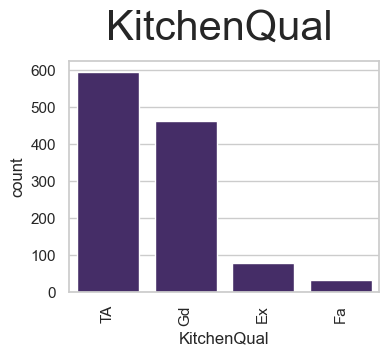

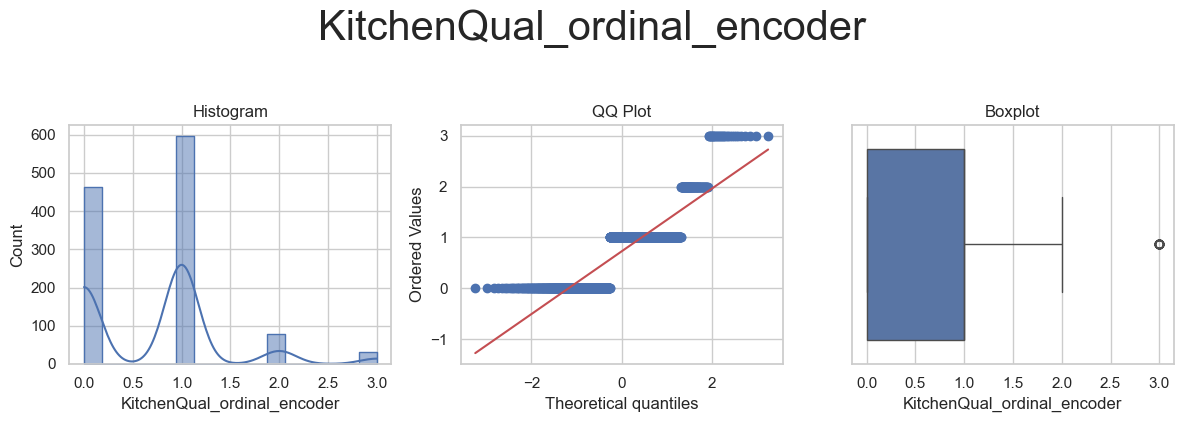

In [19]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [14]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block after 'try' statement on line 2 (2852421808.py, line 5)